In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder,  OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

# Data preprocessing

### Get dataset and remove extrem values based on analysis : https://downloads.hindawi.com/journals/mpe/2021/1162553.pdf

In [2]:
# Get dataset
train_data=pd.read_csv("train.csv")

# Remove extrem datas
train_data=train_data.drop([train_data.index[427]])
train_data=train_data.drop([train_data.index[374]])
train_data=train_data.drop([train_data.index[827]])

for i in range(4):
    train_data=train_data.drop([train_data.index[train_data.charges.idxmax()]])

for i in range(3):
    train_data=train_data.drop([train_data.index[train_data.bmi.idxmax()]])

# Get target
y=train_data.pop("charges")

### Add BFI feature
The Body Fat Index (BFI) allows to evaluate the proportion of fat in the body of the individual. 

With different margins of error, the most used is the Deurenberg formula, a precursor in this field. A preliminary calculation of the BMI is necessary.

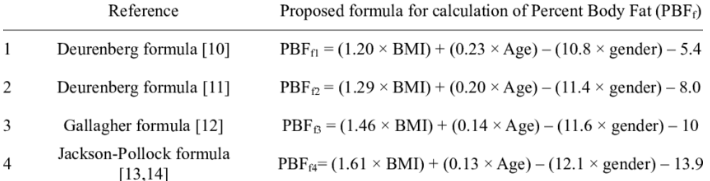

In [3]:
def get_bfi(data):
    sex_ord=data["sex"].replace('male',1)
    sex_ord=sex_ord.replace('female',0)

    return ((((1.2*data['bmi'])+(0.23*data['age'])-(10.8*sex_ord)-5.4)))

train_data['bfi']=get_bfi(train_data)

### Define categories

In [4]:
cat_data_col=['sex', 'smoker', 'region']
ordinal_data_col=['children']
continous_data_col=['age', 'bmi', 'bfi']

### Define transform pipeline into column transformer

In [5]:
cat_pipeline = Pipeline([
        ('onehot', OneHotEncoder()),
    ])

ordinal_pipeline = Pipeline([
        ('ordinal', OrdinalEncoder()),      
    ])

continous_pipeline = Pipeline([
        ('minmax', MinMaxScaler()),
    ])

In [6]:
column_transformer=ColumnTransformer([
    ("cont", continous_pipeline, continous_data_col),
    ("cat", cat_pipeline, cat_data_col),
    ("ord", ordinal_pipeline, ordinal_data_col)
])

### Preprocess data

In [7]:
X=column_transformer.fit_transform(train_data)

### Split into train and test data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

# Grid Search for LGBM  model

### Define params to find best model

In [9]:
params={
    'boosting_type':['gbdt'],
    'n_estimators':[100,60,80],
    'num_leaves':[25,30,20],
    'max_depth':[2,4,6,8],
    'learning_rate':[0.05, 0.06,0.04],

         }

grida=GridSearchCV(lgb.LGBMRegressor(), params, cv=4)
grida.fit(X, y)

print("Best parameters for LGBM model are :", grida.best_params_)
print("With the score of :", grida.best_score_)

Best parameters for LGBM model are : {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 80, 'num_leaves': 25}
With the score of : 0.8655065361398095


## GBDT

In [16]:
lgb_model_gbdt=lgb.LGBMRegressor(objective = 'regression',
                            boosting_type='gbdt',
                            learning_rate=0.05,
                            max_depth=4,
                            n_estimators=80,
                            num_leaves=25,                               
                                )

lgb_model_gbdt.fit(X_train,y_train) 

print('LGBM :', r2_score(y_test, lgb_model_gbdt.predict(X_test)))

LGBM : 0.8663301315205534


# Submit prediction

### Get test dataset 

In [11]:
test_dataset=pd.read_csv("test.csv")

### Add BFI feature

In [12]:
test_dataset['bfi']=get_bfi(test_dataset)

### Transform

In [13]:
X_final = column_transformer.transform(test_dataset)

### Fit and predict

In [14]:
lgb_model_gbdt.fit(X, y)
predicted_charges=lgb_model_gbdt.predict(X_final)

### Merge result

In [15]:
result=pd.read_csv("test.csv")
result=result.set_index('trustii_id')
result['charges'] = predicted_charges

### Submit

In [185]:
result.to_csv('last_lgbm.csv',encoding='UTF-8')
result

,age,sex,bmi,children,smoker,region,charges
trustii_id,,,,,,,
1,51,female,34.960,2,yes,northeast,45057.381332
2,52,male,36.765,2,no,northwest,13543.256386
3,46,female,27.720,1,no,southeast,8605.973160
4,48,male,37.290,2,no,southeast,11193.922852
5,35,female,23.465,2,no,northeast,8707.132086
...,...,...,...,...,...,...,...
398,27,male,31.130,1,yes,southeast,35410.800475
399,52,female,30.875,0,no,northeast,11283.157655
400,52,male,32.775,3,no,northwest,13776.339031
